# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
data_dir = 'flower_data'

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
batch_size = 64
num_classes = 102

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def build_dataloaders(input_size):

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'valid': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }

    image_datasets = {s: datasets.ImageFolder(os.path.join(data_dir, s), data_transforms[s])
                      for s in ['train', 'valid']
                     }

    dataloaders = {s: DataLoader(image_datasets[s], batch_size=batch_size, shuffle=True, num_workers=num_workers)
                   for s in ['train', 'valid']
                  }
    return image_datasets, dataloaders

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
list(cat_to_name.items())[:10]

[('21', 'fire lily'),
 ('3', 'canterbury bells'),
 ('45', 'bolero deep blue'),
 ('1', 'pink primrose'),
 ('34', 'mexican aster'),
 ('27', 'prince of wales feathers'),
 ('7', 'moon orchid'),
 ('16', 'globe-flower'),
 ('25', 'grape hyacinth'),
 ('26', 'corn poppy')]

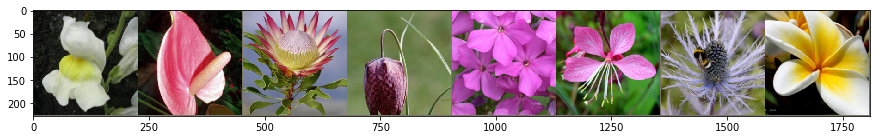

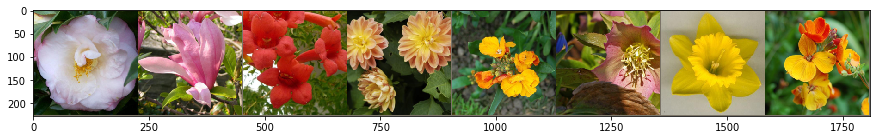

In [5]:
def grid_show(inputs):
    images = torchvision.utils.make_grid(inputs)
    images = images.numpy().transpose((1, 2, 0))
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    

_, dataloaders = build_dataloaders(224)
for s in ['train', 'valid']:
    plt.figure(figsize=(15, 12))
    inputs, _ = next(iter(dataloaders[s]))
    grid_show(inputs[:8])


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

### Init models functions

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
def init_model(model_name, num_classes, feature_extract=True, use_pretrained=True):
    
    model_ft = None
    input_size = 0
    
    if model_name == 'resnet':
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == 'alexnet':
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == 'vgg':
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == 'squeezenet':
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
    
    elif model_name == 'densenet':
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == 'inception':
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299
    else:
        print('Invalid model name')
        return None, None
    
    return model_ft, input_size

In [8]:
class WrapperModel(nn.Module):
    def __init__(self, model_name, num_classes, feature_extract=True, use_pretrained=True):
        super().__init__()
        self.model, self.input_size = init_model(model_name, num_classes, feature_extract, use_pretrained)
        
    def forward(self, x):
        x = self.model(x)
        if type(x) is tuple:
            return tuple(F.log_softmax(xi, dim=1) for xi in x) 
        return F.log_softmax(x, dim=1)

In [9]:
def build_optimizer(model):
    params_to_update = []
    for _, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    return optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()
    
    acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
    
        acc = tuple()
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            dataset_size = len(dataloaders[phase].dataset)
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            acc += (epoch_acc,)
            
            print(f'{phase}\tLoss: {epoch_loss:.4f}\tAcc: {epoch_acc:.4f}')
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.copy(model.state_dict())
            if phase == 'valid':
                acc_history.append(acc)
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best Val Acc {best_acc:4f}')
    
    model.load_state_dict(best_model_wts)
    return model, acc_history, best_acc, time_elapsed


In [11]:
criterion = nn.NLLLoss()
num_epochs = 50

results = {}
for model_name in ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']:
    model = WrapperModel(model_name, num_classes)
    input_size = model.input_size
    image_datasets, dataloaders = build_dataloaders(input_size)
    
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model, [0,1])
    model = model.to(device)
    
    optimizer = build_optimizer(model)
    print('=' * 90)
    print(model_name)
    print('=' * 90)
    model, acc_history, best_acc, time_elapsed = train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=(model_name == 'inception')) 
    
    results[model_name] = {
        'model': model,
        'acc_history': acc_history,
        'best_acc': best_acc,
        'time_elapsed': time_elapsed,
        'class_to_idx': image_datasets['train'].class_to_idx
    }

resnet
Epoch 0/49
----------
train	Loss: 4.2745	Acc: 0.1189
valid	Loss: 3.7621	Acc: 0.2335

Epoch 1/49
----------
train	Loss: 3.4863	Acc: 0.3188
valid	Loss: 3.0975	Acc: 0.4059

Epoch 2/49
----------
train	Loss: 2.9102	Acc: 0.4576
valid	Loss: 2.5914	Acc: 0.5183

Epoch 3/49
----------
train	Loss: 2.4669	Acc: 0.5708
valid	Loss: 2.2092	Acc: 0.6235

Epoch 4/49
----------
train	Loss: 2.1307	Acc: 0.6485
valid	Loss: 1.8876	Acc: 0.6968

Epoch 5/49
----------
train	Loss: 1.8636	Acc: 0.7233
valid	Loss: 1.6935	Acc: 0.7518

Epoch 6/49
----------
train	Loss: 1.6444	Acc: 0.7715
valid	Loss: 1.4927	Acc: 0.7873

Epoch 7/49
----------
train	Loss: 1.4765	Acc: 0.8063
valid	Loss: 1.3583	Acc: 0.8178

Epoch 8/49
----------
train	Loss: 1.3257	Acc: 0.8327
valid	Loss: 1.2314	Acc: 0.8227

Epoch 9/49
----------
train	Loss: 1.2074	Acc: 0.8516
valid	Loss: 1.1133	Acc: 0.8435

Epoch 10/49
----------
train	Loss: 1.1126	Acc: 0.8671
valid	Loss: 1.0234	Acc: 0.8557

Epoch 11/49
----------
train	Loss: 1.0197	Acc: 0.8765
val

valid	Loss: 0.3871	Acc: 0.8973

Epoch 41/49
----------
train	Loss: 0.1342	Acc: 0.9690
valid	Loss: 0.3874	Acc: 0.8949

Epoch 42/49
----------
train	Loss: 0.1365	Acc: 0.9675
valid	Loss: 0.3836	Acc: 0.9034

Epoch 43/49
----------
train	Loss: 0.1343	Acc: 0.9683
valid	Loss: 0.3830	Acc: 0.8912

Epoch 44/49
----------
train	Loss: 0.1354	Acc: 0.9698
valid	Loss: 0.3898	Acc: 0.8863

Epoch 45/49
----------
train	Loss: 0.1333	Acc: 0.9692
valid	Loss: 0.3848	Acc: 0.8973

Epoch 46/49
----------
train	Loss: 0.1265	Acc: 0.9693
valid	Loss: 0.3849	Acc: 0.8961

Epoch 47/49
----------
train	Loss: 0.1252	Acc: 0.9702
valid	Loss: 0.3873	Acc: 0.9010

Epoch 48/49
----------
train	Loss: 0.1214	Acc: 0.9734
valid	Loss: 0.3909	Acc: 0.8875

Epoch 49/49
----------
train	Loss: 0.1205	Acc: 0.9724
valid	Loss: 0.3787	Acc: 0.8961

Training complete in 13m 21s
Best Val Acc 0.903423
vgg
Epoch 0/49
----------
train	Loss: 4.0284	Acc: 0.1737
valid	Loss: 3.3053	Acc: 0.3802

Epoch 1/49
----------
train	Loss: 2.9345	Acc: 0.4318
v

/work/05791/andrec/maverick2/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/work/05791/andrec/maverick2/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


squeezenet
Epoch 0/49
----------
train	Loss: 3.4382	Acc: 0.2833
valid	Loss: 1.9782	Acc: 0.5526

Epoch 1/49
----------
train	Loss: 1.4868	Acc: 0.6650
valid	Loss: 1.1020	Acc: 0.7396

Epoch 2/49
----------
train	Loss: 0.9110	Acc: 0.7921
valid	Loss: 0.7728	Acc: 0.8117

Epoch 3/49
----------
train	Loss: 0.6829	Acc: 0.8455
valid	Loss: 0.6320	Acc: 0.8545

Epoch 4/49
----------
train	Loss: 0.5501	Acc: 0.8773
valid	Loss: 0.5540	Acc: 0.8655

Epoch 5/49
----------
train	Loss: 0.4646	Acc: 0.9006
valid	Loss: 0.4922	Acc: 0.8814

Epoch 6/49
----------
train	Loss: 0.4102	Acc: 0.9118
valid	Loss: 0.4704	Acc: 0.8863

Epoch 7/49
----------
train	Loss: 0.3636	Acc: 0.9225
valid	Loss: 0.4443	Acc: 0.8985

Epoch 8/49
----------
train	Loss: 0.3298	Acc: 0.9290
valid	Loss: 0.4278	Acc: 0.8924

Epoch 9/49
----------
train	Loss: 0.2998	Acc: 0.9376
valid	Loss: 0.4057	Acc: 0.9046

Epoch 10/49
----------
train	Loss: 0.2744	Acc: 0.9446
valid	Loss: 0.3855	Acc: 0.9071

Epoch 11/49
----------
train	Loss: 0.2574	Acc: 0.9496

/work/05791/andrec/maverick2/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


densenet
Epoch 0/49
----------
train	Loss: 4.2256	Acc: 0.1250
valid	Loss: 3.7235	Acc: 0.2873

Epoch 1/49
----------
train	Loss: 3.3953	Acc: 0.3700
valid	Loss: 2.9940	Acc: 0.4853

Epoch 2/49
----------
train	Loss: 2.7708	Acc: 0.5275
valid	Loss: 2.4742	Acc: 0.5795

Epoch 3/49
----------
train	Loss: 2.3027	Acc: 0.6366
valid	Loss: 2.0711	Acc: 0.6785

Epoch 4/49
----------
train	Loss: 1.9523	Acc: 0.7201
valid	Loss: 1.7465	Acc: 0.7518

Epoch 5/49
----------
train	Loss: 1.6766	Acc: 0.7778
valid	Loss: 1.5198	Acc: 0.7934

Epoch 6/49
----------
train	Loss: 1.4584	Acc: 0.8304
valid	Loss: 1.3356	Acc: 0.8203

Epoch 7/49
----------
train	Loss: 1.2818	Acc: 0.8600
valid	Loss: 1.1991	Acc: 0.8313

Epoch 8/49
----------
train	Loss: 1.1438	Acc: 0.8831
valid	Loss: 1.0807	Acc: 0.8509

Epoch 9/49
----------
train	Loss: 1.0290	Acc: 0.8994
valid	Loss: 0.9994	Acc: 0.8778

Epoch 10/49
----------
train	Loss: 0.9382	Acc: 0.9118
valid	Loss: 0.8917	Acc: 0.8826

Epoch 11/49
----------
train	Loss: 0.8569	Acc: 0.9179
v

valid	Loss: 1.0524	Acc: 0.8374

Epoch 41/49
----------
train	Loss: 1.2657	Acc: 0.8523
valid	Loss: 1.0504	Acc: 0.8447

Epoch 42/49
----------
train	Loss: 1.2388	Acc: 0.8512
valid	Loss: 1.0302	Acc: 0.8386

Epoch 43/49
----------
train	Loss: 1.2336	Acc: 0.8542
valid	Loss: 1.0158	Acc: 0.8447

Epoch 44/49
----------
train	Loss: 1.1946	Acc: 0.8588
valid	Loss: 0.9872	Acc: 0.8533

Epoch 45/49
----------
train	Loss: 1.1788	Acc: 0.8613
valid	Loss: 0.9554	Acc: 0.8496

Epoch 46/49
----------
train	Loss: 1.1644	Acc: 0.8597
valid	Loss: 0.9667	Acc: 0.8533

Epoch 47/49
----------
train	Loss: 1.1439	Acc: 0.8625
valid	Loss: 0.9489	Acc: 0.8496

Epoch 48/49
----------
train	Loss: 1.1212	Acc: 0.8663
valid	Loss: 0.9572	Acc: 0.8582

Epoch 49/49
----------
train	Loss: 1.1096	Acc: 0.8658
valid	Loss: 0.9098	Acc: 0.8570

Training complete in 20m 26s
Best Val Acc 0.858191


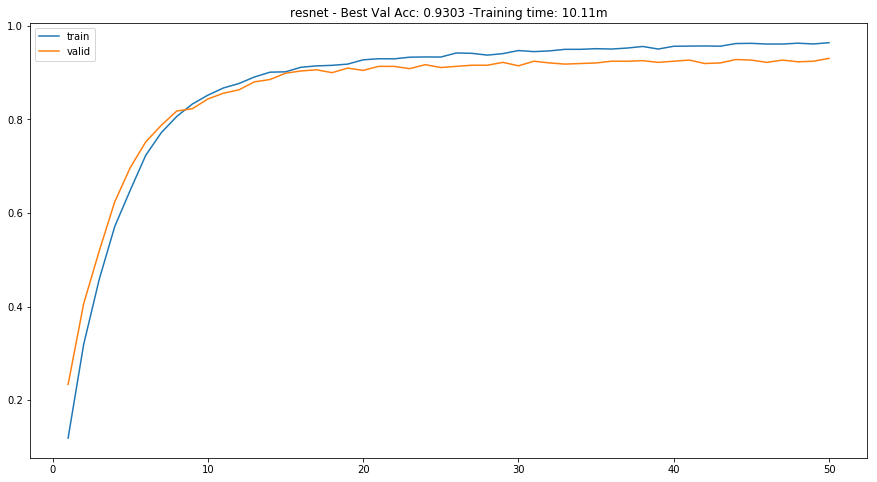

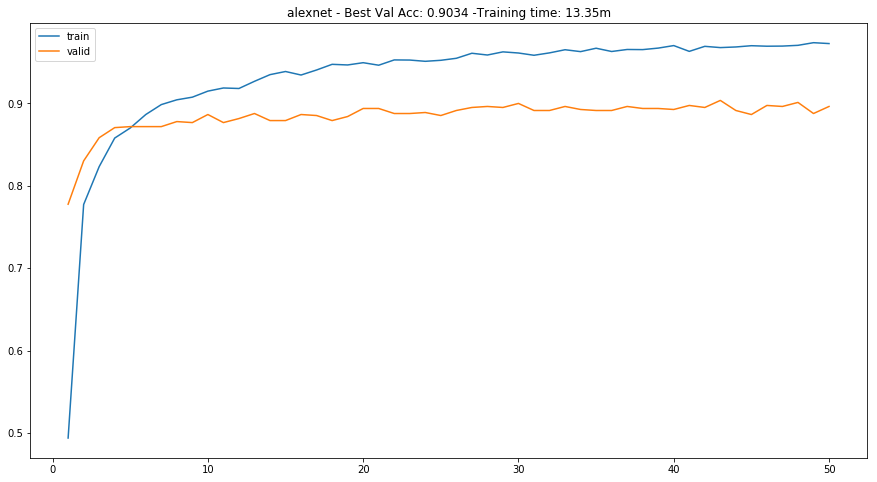

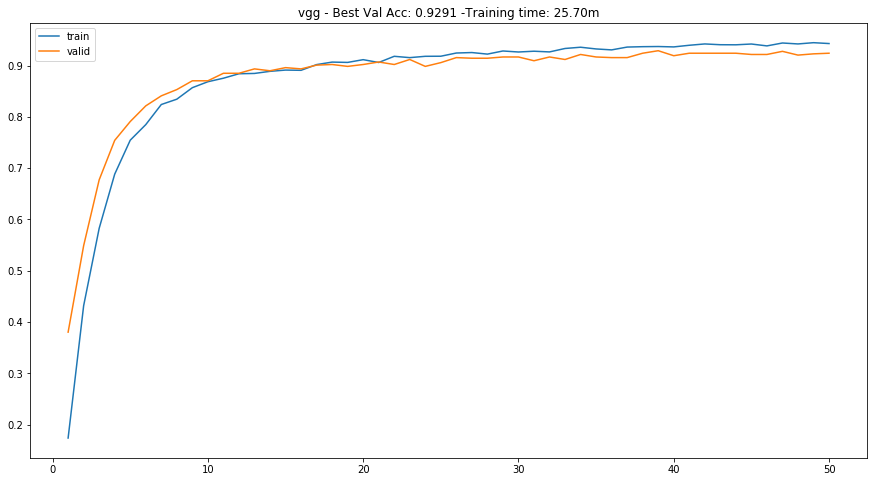

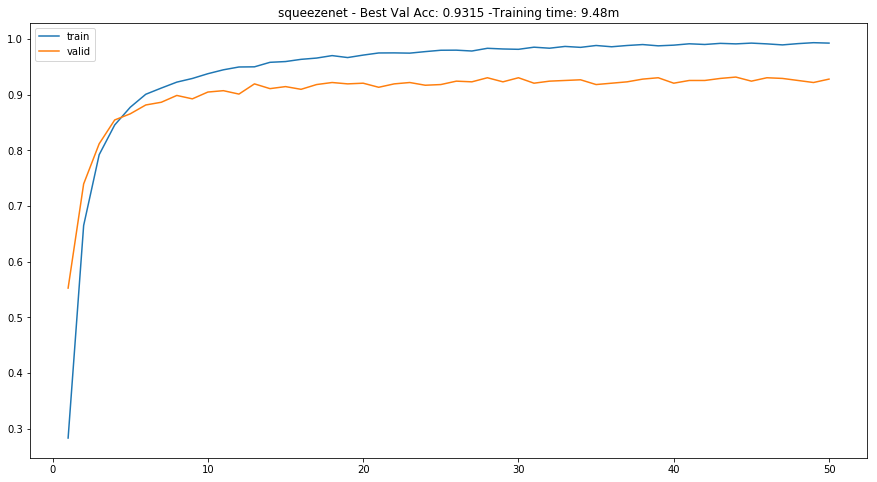

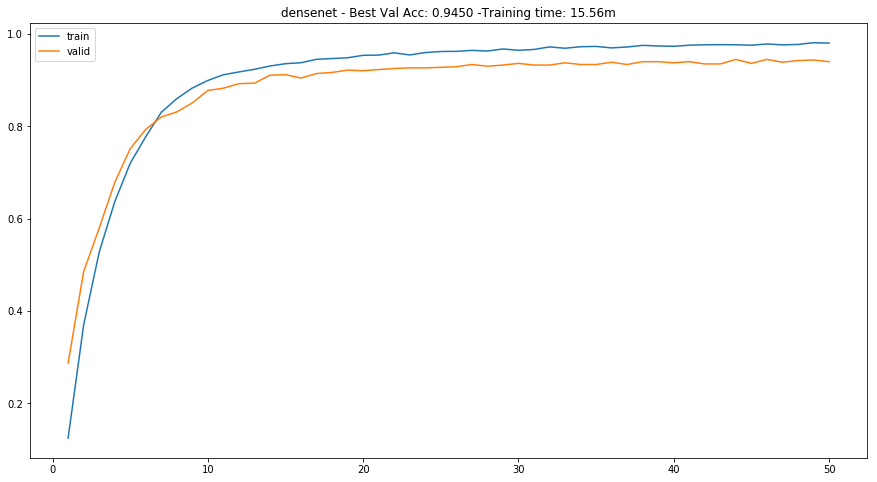

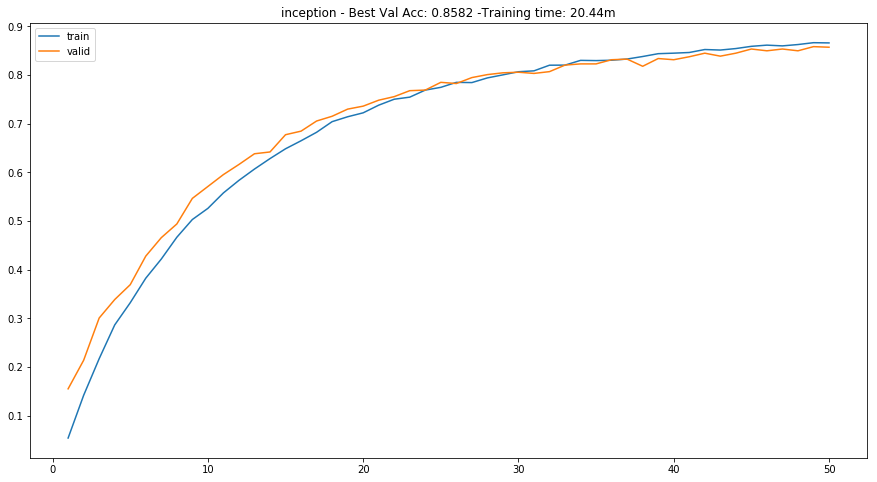

In [12]:
epochs = np.arange(1, num_epochs + 1, 1)
for model_name, model_results in results.items():
    plt.figure(figsize=(15, 8))
    lineObjs = plt.plot(epochs, model_results['acc_history'])
    plt.legend(lineObjs, ('train', 'valid'))
    plt.title(f"{model_name} - "
              f"Best Val Acc: {model_results['best_acc'].item():.4f} -" 
              f"Training time: {model_results['time_elapsed']/60:.2f}m")

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [23]:
# TODO: Save the checkpoint 
for model_name, model_results in results.items():
    results_filename = f'./{model_name}.cpu.tar'
    print(results_filename)
    
    model = model_results['model'].module.cpu()
    torch.save({
        'model': model.state_dict(),
        'class_to_idx': model_results['class_to_idx'],
    }, results_filename)


./resnet.cpu.tar
./alexnet.cpu.tar
./vgg.cpu.tar
./squeezenet.cpu.tar
./densenet.cpu.tar
./inception.cpu.tar


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [15]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
model_name = 'vgg'
checkpoint = torch.load(f'{model_name}.tar')
model = WrapperModel(model_name, num_classes)
input_size = model.input_size
model.load_state_dict(checkpoint['model'])
model.eval()

class_to_idx = checkpoint['class_to_idx']
idx_to_class = {v: k for k, v in class_to_idx.items()}

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model, [0,1])
model = model.to(device)
input_size, model

(224, DataParallel(
   (module): WrapperModel(
     (model): VGG(
       (features): Sequential(
         (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU(inplace)
         (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (6): ReLU(inplace)
         (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (10): ReLU(inplace)
         (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (12): BatchNorm2d(256,

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [16]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    img = Image.open(image)
    target_resize = 256
    old_size = img.size
    ratio = target_resize / min(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    img = img.resize(new_size)
    left = (new_size[0] - input_size) / 2
    top = (new_size[1] - input_size) / 2
    right = (new_size[0] + input_size) / 2
    bottom = (new_size[1] + input_size) / 2
    img = img.crop((left, top, right, bottom))
    
    np_image = np.array(img)
    np_image = np_image / 255
    np_image = (np_image - mean)/std
    np_image = np_image.transpose((2, 0, 1))
    
    return torch.from_numpy(np_image)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [17]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

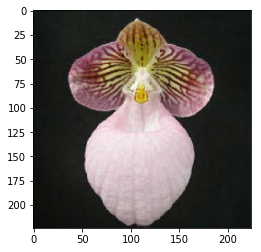

In [18]:
imshow(process_image('flower_data/valid/2/image_05136.jpg'));

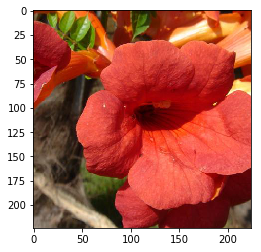

In [19]:
imshow(process_image('flower_data/train/101/image_07946.jpg'));

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [20]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    image = process_image(image_path)
    image = image.unsqueeze(0)
    image = image.to(device).float()
    log_pred = model(image)
    log_pred = log_pred.cpu().detach().squeeze()
    pred = torch.exp(log_pred) 
    probs, labels = pred.topk(topk)
    probs = list(probs.numpy())
    classes = [idx_to_class[l] for l in labels.numpy()]
    return probs, classes
    

In [21]:
predict('flower_data/valid/2/image_05136.jpg', model)

([0.9999924, 1.6621402e-06, 1.6076389e-06, 5.159688e-07, 3.185492e-07],
 ['2', '18', '52', '48', '16'])

In [22]:
predict('flower_data/valid/14/image_06082.jpg', model)

([0.99342704, 0.0044740294, 0.0011023855, 0.0007096551, 0.00013497288],
 ['14', '35', '10', '29', '12'])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes